# Santander customer satisfaction challenge

## Problem

Customer satisfaction is a key measure of success for all businesses. Unhappy customers don't stay with the same provider and they rarely voice their dissatisfaction before leaving. In this context, Santander bank launched a challenge in Kaggle in order to build models that predict potential unhappy customers

---



## Objective

The objective of this competition is to be able to identify unhappy customers early and anticipate their leaving which would allow the company to take proactive steps to improve a customer's happiness before it's too late. In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

## Data

The data is an anonymized dataset containing a large number of numeric variables. The "TARGET" column is the variable to predict. It equals 1 for unsatisfied customers and 0 for satisfied customers. The task is to predict the probability that each customer in the test set is an unsatisfied customer.
- train.csv: (371 columns): The training set including the target
- test.csv: (370 columns): The test set without the target

##Install Vectice and GCS packages


Vectice provides a generic metadata layer that is potentially suitable for most data science workflows. For this tutorial we will use the sickit-learn library for modeling and track experiments directly through our Python SDK to illustrate how to fine-tune exactly what you would like to track: metrics, etc. The same mechanisms would apply to R, Java or even more generic REST APIs to track metadata from any programming language and library.

Here is a link to the Python SDK Documentation, it's not final nor complete and it is updated as we go along. 
[Python SDK Documentation](https://storage.googleapis.com/sdk-documentation/index.html)

## This is a copy

In [2]:
print('Hello world! From GCP using gitlab')

Hello world! From GCP using gitlab


In [1]:
print('modif from gcp terminal using gitlab')

modif from gcp terminal using gitlab


In [5]:
!pip3 install -q fsspec
!pip3 install -q gcsfs
!pip3 install -q vectice

In [6]:
!pip3 show vectice

Name: vectice
Version: 0.0.6
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: GitPython, python-dotenv, PyGithub, requests
Required-by: 


## Install the required packages

**Especially if you're working locally and you didn't already install them**

In [7]:
!pip install -q numpy
!pip install -q pandas
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q sklearn
!pip install -q lightgbm
!pip install -q imblearn

## Import the required packages


In [8]:
import os
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from vectice.models import JobType
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, auc
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
from lightgbm import plot_importance
from imblearn.over_sampling import SMOTE

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Retreive the data from GS

In [9]:
# Load your json key file to access GCS that was provided with your tutorial account 
# The name should be something like test.json
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [10]:
# Once your file is loaded set the credentials for GCS and load the file
# in a pandas frame, double check the json file name you uploaded below.

## Complete with the name of your json key file access to GCS that was provided with your tutorial account

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'sandbox-storage-read-only.json'

# The original source dataset is already declared in the Vectice UI as "customer_satisfaction_train"
# and its connection to "gs://vectice-examples-samples/Customer_satisfaction_challenge/" has been established
train_df = pd.read_csv("gs://vectice-examples-samples/Customer_satisfaction_challenge/dataset.csv")
# Run head to make sure the data was loaded properly
print(train_df.head())

   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...

## Data exploration

Data exploration enables us to take a first look on the data, can enhance the overall understanding of the characteristics of the data domain and helps to detect correlation between the features, thereby allowing for the creation of more accurate models

In [11]:
print("Train Data Shape : ",train_df.shape)

Train Data Shape :  (76020, 371)


In [12]:
train_df['TARGET'].value_counts()


0    73012
1     3008
Name: TARGET, dtype: int64

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [14]:
train_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

In [15]:
features = train_df.drop(['ID','TARGET'],axis=1)

## Exploratory data analysis (EDA)
* Target Percent
* Check Multicollinearity
* Check Outlier

EDA is a technique that helps to explore and understand the data sets by summarizing their main characteristics often plotting them visually. It consists of Histograms, Box plot, Scatter plot and many more. EDA is about gathering as many insights from data as we can in order to understand it

In [16]:
pd.DataFrame(train_df['TARGET'].value_counts())

TARGET
0   73012
1    3008

The training set is way imbalanced (73012 zeros vs 3008 ones), so some algorithms may learn mostly from the 0 which can affect our predictions. We address that by using oversampling


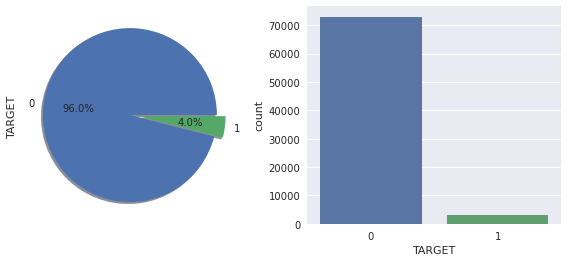

In [17]:
f, ax = plt.subplots(1,2,figsize=(10,4))
train_df['TARGET'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)
sns.countplot('TARGET', data=train_df, ax=ax[1])
plt.show()

In [18]:
null_value = train_df.isnull().sum().sort_values(ascending=False)
null_percent = round(train_df.isnull().sum().sort_values(ascending=False)/len(train_df)*100,2)
pd.concat([null_value, null_percent], axis=1, keys=['Null values', 'Percent'])

Null values  Percent
ID                                 0      0.0
imp_trasp_var17_in_ult1            0      0.0
ind_var7_emit_ult1                 0      0.0
imp_venta_var44_ult1               0      0.0
imp_venta_var44_hace3              0      0.0
...                              ...      ...
num_op_var40_hace3                 0      0.0
num_op_var40_hace2                 0      0.0
num_var25                          0      0.0
num_var25_0                        0      0.0
TARGET                             0      0.0

[371 rows x 2 columns]

Ther is no column with null values

**Correlation**

If we have a big correlation, we have a problem of multicolinearity. That means that there are some features that depend of other features, so we should reduce the dimentionality of our data (if A depends of B, we should either find a way to aggregate or combine the two features and turn it into one variable or drop one of the variables that are too highly correlated with another) and that can be adressed using Principal component analysis (PCA)

In [19]:
features[features.columns[:8]].corr()

var3     var15  imp_ent_var16_ult1  \
var3                     1.000000 -0.004452            0.001868   
var15                   -0.004452  1.000000            0.043722   
imp_ent_var16_ult1       0.001868  0.043722            1.000000   
imp_op_var39_comer_ult1  0.005989  0.094762            0.041221   
imp_op_var39_comer_ult3  0.006817  0.101177            0.034879   
imp_op_var40_comer_ult1  0.001518  0.042754            0.009896   
imp_op_var40_comer_ult3  0.001690  0.048512            0.009377   
imp_op_var40_efect_ult1  0.000530  0.008805            0.000592   

                         imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
var3                                    0.005989                 0.006817   
var15                                   0.094762                 0.101177   
imp_ent_var16_ult1                      0.041221                 0.034879   
imp_op_var39_comer_ult1                 1.000000                 0.886476   
imp_op_var39_comer_ult3                 0.886476                 1.000000   
imp_op_var40_comer_ult1                 0.342709                 0.316671   
imp_op_var40_comer_ult3                 0.295295                 0.355670   
imp_op_var40_efect_ult1                 0.032280                 0.029094   

                         imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
var3                                    0.001518                 0.001690   
var15                                   0.042754                 0.048512   
imp_ent_var16_ult1                      0.009896                 0.009377   
imp_op_var39_comer_ult1                 0.342709                 0.295295   
imp_op_var39_comer_ult3                 0.316671                 0.355670   
imp_op_var40_comer_ult1                 1.000000                 0.852206   
imp_op_var40_comer_ult3                 0.852206                 1.000000   
imp_op_var40_efect_ult1                 0.061187                 0.053579   

                         imp_op_var40_efect_ult1  
var3                                    0.000530  
var15                                   0.008805  
imp_ent_var16_ult1                      0.000592  
imp_op_var39_comer_ult1                 0.032280  
imp_op_var39_comer_ult3                 0.029094  
imp_op_var40_comer_ult1                 0.061187  
imp_op_var40_comer_ult3                 0.053579  
imp_op_var40_efect_ult1                 1.000000

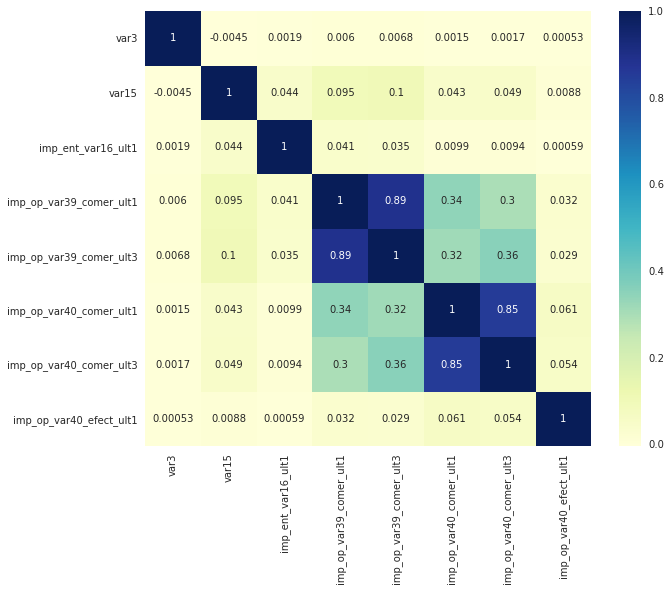

In [20]:
sns.heatmap(features[features.columns[:8]].corr(),annot=True,cmap='YlGnBu')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

=> We Can Check Multicollinearity

Multicollinearity is a phenomenon in which one independent variable is highly correlated with one or more of the other independent variables

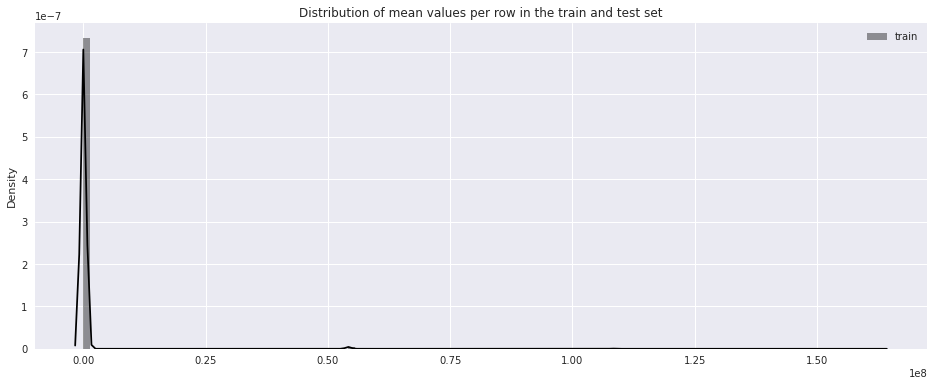

In [21]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features.columns].mean(axis=1),color="black", kde=True,bins=120, label='train')
plt.legend()
plt.show()

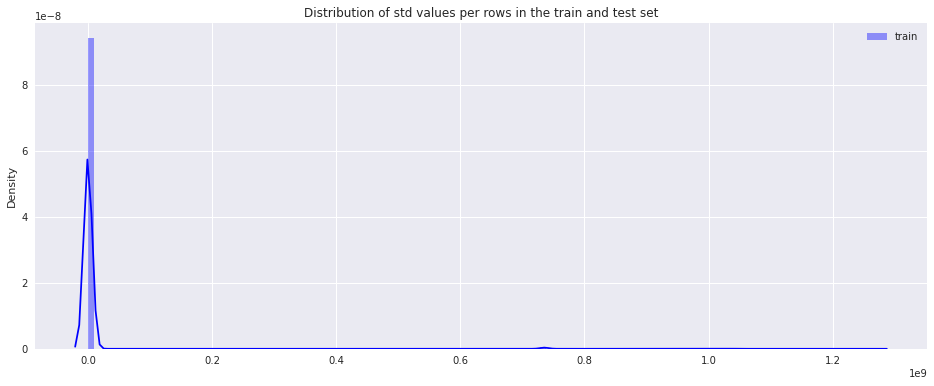

In [22]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train_df[features.columns].std(axis=1),color="blue",kde=True,bins=120, label='train')
plt.legend(); plt.show()

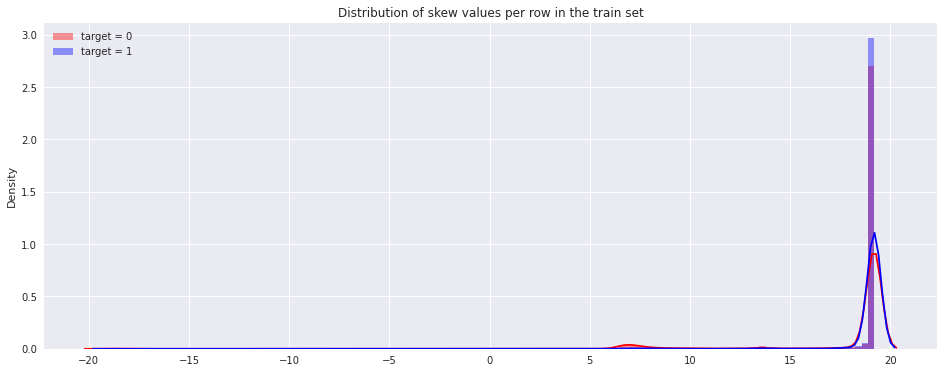

In [23]:
t0 = train_df[train_df['TARGET'] == 0]
t1 = train_df[train_df['TARGET'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features.columns].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features.columns].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

=> We Can Check Outlier

An outlier is a value or point that differs substantially from the rest of the data

In [24]:
train_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

{'whiskers': [<matplotlib.lines.Line2D at 0x7f16d44cea10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f16d44ce550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f16d44ce110>],
 'medians': [<matplotlib.lines.Line2D at 0x7f16d44aded0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f16d44ad610>],
 'means': []}

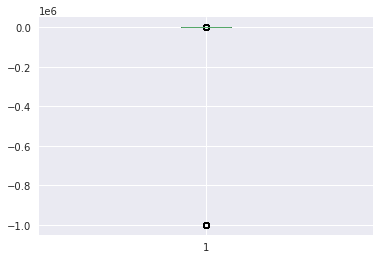

In [25]:
plt.boxplot(train_df['var3'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f16d46c8f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f16d467c3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f16d46c8a50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f16d4672190>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f16d4672a50>],
 'means': []}

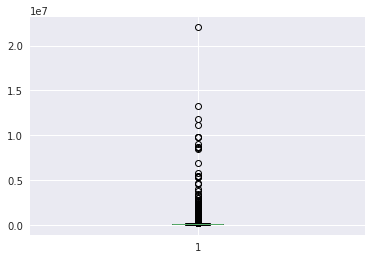

In [26]:
plt.boxplot(train_df['var38'])

The training set:
- Contains continuous and and catigorized data (we should treate carigorized data cuz 10000>1 if we interpret them as numeric values and not catigorical (example IDs)
- Contains variables with zero variance or non predictive value
- Contains fake values (-999999) that were introduced to replace missing data
- Is way imbalanced

## Preprocessing
Data preprocessing alludes to the method of cleaning and arranging the crude data to make it appropriate for building and preparing AI models. Data preprocessing is a procedure that changes crude data into an instructive and lucid arrangement. Our dataset is imbalanced. We will use oversampling to resolve this problem because if not some algorithms will learn more from the zeros than the ones in our training dataset


* Processing Outlier Values

In [27]:
train_df['var3'].replace(-999999,2,inplace=True)
train_df.describe()

ID          var3         var15  imp_ent_var16_ult1  \
count   76020.000000  76020.000000  76020.000000        76020.000000   
mean    75964.050723      2.716483     33.212865           86.208265   
std     43781.947379      9.447971     12.956486         1614.757313   
min         1.000000      0.000000      5.000000            0.000000   
25%     38104.750000      2.000000     23.000000            0.000000   
50%     76043.000000      2.000000     28.000000            0.000000   
75%    113748.750000      2.000000     40.000000            0.000000   
max    151838.000000    238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   
mean    

## Connect to your Vectice project

Here we are going to need an API token and a project token. An API token is used to secure requests between your existing tools and Vectice. You can create and manage those at the API Tokens tab in your workspace, and they impersonate you and your rights per workspace, so we strongly recommend you to avoid sharing them.
A project token is used to target the project you're working on in the UI and can found (after creating a project) in the Project settings page, and anyone working on the project can see it and copy/paste it.

In [ ]:
# In order to use Vectice SDK, let's set up the configurations first.
# The Vectice API key below can be generated from the UI.
# For better security, the settings can also be put into a dedicated file called `.vectice` or `.env`.
## Make sure that you're using the right endpoint (hint: be-beta.vectice.com)
os.environ['VECTICE_API_ENDPOINT']= ""
os.environ['VECTICE_API_TOKEN'] = ""

## Create a Vetice instance to connect to your project using your project token
## Hint: Do not forget to import vectice (from vectice import Vectice)
vectice = Vectice(project_token="")

print(vectice)

In [28]:
#@title Double click to show the syntax
os.environ['VECTICE_API_ENDPOINT']= "be-test.vectice.com"
##Complete with your Vectice API token
os.environ['VECTICE_API_TOKEN'] = "NKBkPJ25j.m6QdAkPDrWYwRZxXEOJLeNKBkPJ25j3VgzlypaGnM41bq89omv"
from vectice import Vectice
## Complete with your project token
vectice = Vectice(project_token="Kvbr2g6EIk6rkpWBwdV5")
print(vectice)

## Feature Engineering

It's about creating new input features from your existing ones and can be seen as a process of addition that helps to improve the mode's performance by :
- Isolating and highlighting key information, which helps the algorithms "focus" on what’s important.
- You can bring in your own domain expertise.
- Most importantly, once you understand the "vocabulary" of feature engineering, you can bring in other people’s domain expertise!

In this part we will:
* Split Data to Train / Test 
* Train Data to Standard Scaler
* Target Data to Oversampling by SMOTE

In [29]:
train_df.drop('ID',axis=1,inplace=True)

In [30]:
x = train_df.drop('TARGET',axis=1)
y = train_df['TARGET']

### Resolving the problem of multicolinearity

Here we are going to use the "The Pearson correlation" method. It is the most common method to use for numerical variables; it assigns a value between − 1 and 1, where 0 is no correlation, 1 is total positive correlation, and − 1 is total negative correlation. This is interpreted as follows: a correlation value of 0.7 between two variables would indicate that a significant and positive relationship exists between the two. A positive correlation signifies that if variable A goes up, then B will also go up, whereas if the value of the correlation is negative, then if A increases, B decreases

In [31]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

We consider a threshold of 0.9 to avoid high correlation

In [32]:
corr_features = correlation(x, 0.9)
len(set(corr_features))

166

In [33]:
x = x.drop(corr_features,axis=1)

### Standardize data

StandardScaler is an important technique that is mainly performed as a preprocessing step before many machine learning models, in order to standardize the range of functionality of the input dataset. It's used to resize the distribution of values ​​so that the mean of the observed values ​​is 0 and the standard deviation is 1

In [34]:
scaler = StandardScaler().fit(x)
x_scaler = scaler.transform(x)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

**Principal component analysis (PCA)** 

It's a statistical technique used for data reduction without losing its properties. Using PCA can help identify correlations between data points. PCA creates a visualization of data that minimizes residual variance in the least squares sense and maximizes the variance of the projection coordinates

In [ ]:
pca = PCA(n_components=0.95)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)

In [ ]:
x_scaler_pca_df.head()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
plt.scatter(x_scaler_pca_df.loc[:, 0], x_scaler_pca_df.loc[:, 1], c=y,  cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

=> We cant use PCA since we can't reduce the dimentionality (The variance is represented by multiple variables and we didn't find a small number of variables that enable to represent a considerable part of the variance)

## Split the data and use oversampling

ML algorithms can have a poor performance when dealing with datasets in which one or more classes represent only a small proportion of the overall dataset compared with a dominant class. This problem can be solved by balancing the number of examples between different classes. Here we suggest to you SMOTE (Synthetic Minority Over-sampling Technique) that creates synthetic data based on creating new data points that are mid-way between two near neighbours in any particular class

Create a dataset containing your dataset to use it as input for your splitting data job. That can be done through the UI by going to your project, clicking on datasets and then click on add (you should add a connection to be able to create a dataset)

Create a dataset version based on the dataset you created above

In [ ]:
input_ds_version = ""

In [35]:
#@title Double click to show the syntax
# Use auto-versioning here
input_ds_version =  vectice.create_dataset_version().with_parent_name("customer_satisfaction_jupyter")

The following code splits the dataset to train and test sets and uses the SMOTE methode for oversampling in order to balance our dataset. Please complete itwith creating PREPARATION job run, start it and then declare train_set and test_set as dataset versions (after creating the datasets in the UI) in order to be able to use them as inputs for the different models

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
#Split data
scaler_x_train, scaler_x_test, scaler_y_train, scaler_y_test = train_test_split(x_scaler, y, test_size=0.3)
#Use SMOTE to oversample the dataset
x_over, y_over = SMOTE().fit_resample(scaler_x_train,scaler_y_train)
print(sorted(Counter(y_over).items()))





In [37]:

#@title Double click to show the answer

uri = "https://github.com/Mesto00/Users-Notebooks"
script_relative_path="Notebooks/Vanilla/Customer_satisfaction_example/customer_satisfaction_challenge.ipynb"
input_code = Vectice.create_code_version_with_github_uri(uri=uri, script_relative_path=script_relative_path)

input_ds_version = input_ds_version

# Start a Vectice run. The job type should be PREPARATION in this case.

vectice.create_run("jobSplitData_Customer_Satisfaction", JobType.PREPARATION)
with vectice.start_run(inputs=[input_ds_version,input_code]) as run:
#with vectice.start_run(inputs=[input_ds_version]) as run:

#Split data
    scaler_x_train, scaler_x_test, scaler_y_train, scaler_y_test = train_test_split(x_scaler, y, test_size=0.3)
#Use SMOTE to oversample the dataset
    x_over, y_over = SMOTE().fit_resample(scaler_x_train,scaler_y_train)

##We commented out the code to persist the training and testing test in GCS,
# because we already generated it for you, but feel free to uncomment it and execute it.
# The key you were provided for this tutorial may not have write permissions to GCS.
# Let us know if you want to be able to write files as well and we can issue you a different key.

## Get training and testing data in dataframes in orderto upload them to GCS
  #train_set = pd.DataFrame(x_over, columns=x.columns).join(pd.DataFrame(y_over, columns=["TARGET"]))
  #test_set = pd.DataFrame(scaler_x_test, columns=x.columns).join(pd.DataFrame(scaler_y_test, columns=["TARGET"]))
  #train_set.to_csv (r'gs://vectice-examples-samples/Customer_satisfaction_challenge/training_data.csv', index = False, header = True)
  #test_set.to_csv (r'gs://vectice-examples-samples/Customer_satisfaction_challenge/testing_data.csv', index = False, header = True)

  # Don't forget to create the datasets before creating train_ds_version and test_ds_version 

    train_ds_version = vectice.create_dataset_version().with_parent_name("train_customer_satisfaction_jupyter")
    test_ds_version = vectice.create_dataset_version().with_parent_name("test_customer_satisfaction_jupyter")
  
    run.add_outputs([train_ds_version,test_ds_version])


Our data contains now the same number of zeros and ones now

## Get different user versions


Generate a random user version by calling get_random_string

In [38]:
# Let's generate some unique names for our following modeling experiments
import random
import string
def get_random_string(length):
    return "".join(random.choice(string.ascii_letters) for i in range(length))

# Modeling
* LogisticRegression
* LightGBM Classification

Here we create a function that calculates and shows the confusion matrix and the accuracy, precision, recall, f1_score, roc_auc metrics.

- Confusion matrix: Confusion matrices represent counts from predicted and actual values. It shows the rates of TP, FP, FN and TN
- Accuracy: The model’s capability to correctly predict both the positives and negatives out of all the predictions. Accuracy_score =  (TP + TN)/ (TP + FN + TN + FP)
- Precision: The model's capability to correctly predict the positives out of all the positive prediction it made. Precision Score = TP / (FP + TP)
- Recall: The model’s capability to correctly predict the positives out of actual positives. This is unlike precision which measures as to how many predictions made by models are actually positive out of all positive predictions made. Recall score is a useful measure of success of prediction when the classes are very imbalanced. Recall Score = TP / (FN + TP)
- F1score: The model score as a function of precision and recall score. This is useful measure of the model in the scenarios where one tries to optimize either of precision or recall score and as a result, the model performance suffers.F1_Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score)
- roc_auc_score : ROC curve is a graph that shows the performance of a classification model at all possible thresholds( threshold is a particular value beyond which you say a point belongs to a particular class). AUC measures how well a model is able to distinguish between classes. The curve is plotted between two parameters :
    * TRUE POSITIVE RATE
    * FALSE POSTIVIE RATE
- True Positive (TP): The value of correct predictions of positives out of actual positive cases. Ex : Predict a well person as not sick
- False Positive (FP): The value of incorrect positive predictions. The number of negatives falsly pridected as positives. Ex : Predict a sick person as not sick
- True Negative (TN): The value of correct predictions of negatives out of actual negative cases. Ex : Predict a sick person as sick
- False Negative (FN): The value of incorrect negative predictions. This value represents the number of positives which gets falsely. Predict a well person as sick

In [39]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion')
    print(confusion)
    print('Accuacy : {}'.format(np.around(accuracy,4)))
    print('Precision: {}'.format(np.around(precision,4)))
    print('Recall : {}'.format(np.around(recall,4)))
    print('F1 : {}'.format(np.around(f1,4)))  
    print('ROC_AUC : {}'.format(np.around(roc_auc,4)))
    return confusion, accuracy, precision, recall, f1, roc_auc

* **LogisticRegression**

[Logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is used to calculate the probability of a binary event occurring. For example, predicting if a credit card transaction is fraudulent or not fraudulent or predicting if an incoming email is spam or not spam

The following code creates a Logistic regression model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice (You can look at the examples in the documentation) and don't forget to use the names you generated for your experimints

In [ ]:
#Logistic Regression
## Create a run
##Start the run
lg_reg = LogisticRegression()
lg_reg.fit(x_over, y_over)
pred = lg_reg.predict(scaler_x_test)
pred_proba = lg_reg.predict_proba(scaler_x_test)[:,1]

confusion, accuracy, precision, recall, f1, roc_auc = get_clf_eval(scaler_y_test, pred=pred, pred_proba=pred_proba)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)
  

In [40]:
#@title Double click to show the answer

uri = "https://github.com/Mesto00/Users-Notebooks"
script_relative_path="Notebooks/Vanilla/Customer_satisfaction_example/customer_satisfaction_challenge.ipynb"
input_code = Vectice.create_code_version_with_github_uri(uri=uri, script_relative_path=script_relative_path)
vectice.create_run(job_name = "Train model with Logistic regression", job_type = JobType.TRAINING)

with vectice.start_run(inputs=[train_ds_version,test_ds_version, input_code]) as run:
    lg_reg = LogisticRegression()

    lg_reg.fit(x_over, y_over)
    pred = lg_reg.predict(scaler_x_test)
    pred_proba = lg_reg.predict_proba(scaler_x_test)[:,1]

    confusion, accuracy, precision, recall, f1, roc_auc = get_clf_eval(scaler_y_test, pred=pred, pred_proba=pred_proba)
      
    metrics = [('Accuracy score', accuracy), ("Precision,",precision), ("Recall", recall), ('f1 score', f1), ('ROC_AUC', roc_auc)]

    model_version1 = vectice.create_model_version().with_parent_name("logisticRegression").with_algorithm("Classification : Logistic Regression").with_metrics(metrics).with_user_version(get_random_string(12))
    run.add_outputs([model_version1])

confusion
[[15443  6460]
 [  235   668]]
Accuacy : 0.7064
Precision: 0.0937
Recall : 0.7398
F1 : 0.1664
ROC_AUC : 0.8015


* **LightGBM Classifier**

[LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting classifier in machine learning that uses tree-based learning algorithms. It can handle a large amount of data, less memory usage, has parallel and GPU learning, good accuracy, faster training speed and efficiency

In [41]:
scaler_x_test, scaler_x_val, scaler_y_test, scaler_y_val = train_test_split(scaler_x_test, scaler_y_test, test_size=0.5)

In [42]:
##Setting up the model's parameters
## Feel free to play with the parameters
train_data = lgb.Dataset(x_over, label=y_over)
val_data = lgb.Dataset(scaler_x_val, label=scaler_y_val)
n_estimators = 5000
num_leaves = 20
max_depth = -1
min_data_in_leaf = 80
learning_rate = 0.001
boosting = 'gbdt'
objective = 'binary'
metric = 'auc'
n_jobs = -1
params = {
    'n_estimators': n_estimators,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_data_in_leaf': min_data_in_leaf,
    'learning_rate': learning_rate,
    'boosting': boosting,
    'objective': objective,
    'metric': metric,
    'n_jobs': n_jobs
}

The following code creates a LightGBM classifier model and calculates the metrics related to this model. Complete the code by adding a job run to create a model and send the metrics to Vectice and don't forget to give the names dataset version you created before as inputs to you model

In [ ]:
## Create a run
##Start the run
lgbm = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=300)

# Predicting the output on the Test Dataset 
ypred_lgbm = lgbm.predict(scaler_x_test)
ypred_lgbm
y_pred_lgbm_class = [np.argmax(line) for line in ypred_lgbm]
accuracy_lgbm=accuracy_score(scaler_y_test,y_pred_lgbm_class)
print(accuracy_lgbm)
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(scaler_y_test, ypred_lgbm)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()
print('AUC score:', roc_auc)

## Create a model version and add metrics and properties to it (you can use the function get_random_string defined below in order to be able to generate different user versions)



[LightGBM] [Info] Number of positive: 51109, number of negative: 51109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20053
[LightGBM] [Info] Number of data points in the train set: 102218, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	train's auc: 0.798169
Training until validation scores don't improve for 300 rounds
[2]	train's auc: 0.798169
[3]	train's auc: 0.798169
[4]	train's auc: 0.798169
[5]	train's auc: 0.798169
[6]	train's auc: 0.798169
[7]	train's auc: 0.798169
[8]	train's auc: 0.798169
[9]	train's auc: 0.798169
[10]	train's auc: 0.798169
[11]	train's auc: 0.798169
[12]	train's auc: 0.798169
[13]	train's auc: 0.798169
[14]	train's auc: 0.798169
[15]	train's auc: 0.798169
[16]	train's auc: 0.798169
[17]	t

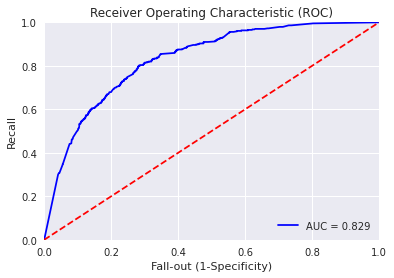

AUC score: 0.8291249913158077


In [43]:
#@title Double click to show the answer

uri = "https://github.com/Mesto00/Users-Notebooks"
script_relative_path="Notebooks/Vanilla/Customer_satisfaction_example/customer_satisfaction_challenge.ipynb"
input_code = Vectice.create_code_version_with_github_uri(uri=uri, script_relative_path=script_relative_path)
vectice.create_run(job_name="Train model with lightgbm", job_type = JobType.TRAINING)

with vectice.start_run(inputs=[train_ds_version,test_ds_version, input_code]) as run:

    lgbm = lgb.train(params,
                    train_data,
                    valid_sets=val_data, 
                    valid_names=['train','valid'],
                    early_stopping_rounds=300)

  # Predicting the output on the Test Dataset 
    ypred_lgbm = lgbm.predict(scaler_x_test)
    ypred_lgbm
    y_pred_lgbm_class = [np.argmax(line) for line in ypred_lgbm]
    accuracy_lgbm=accuracy_score(scaler_y_test,y_pred_lgbm_class)
    print(accuracy_lgbm)
  #Print Area Under Curve
    plt.figure()
    false_positive_rate, recall, thresholds = roc_curve(scaler_y_test, ypred_lgbm)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.show()
    print('AUC score:', roc_auc)

    metrics =[("Accuracy", accuracy_lgbm), ("AUC score", roc_auc)] 
    properties =  [("n_estimators", n_estimators), ("num_leaves", num_leaves), ("max_depth", max_depth),
                ("min_data_in_leaf", min_data_in_leaf), ("learning_rate", learning_rate), ("boosting", boosting),
                ("objective", objective), ("metric", metric), ("n_jobs", n_jobs)]

    model_version2 = vectice.create_model_version().with_parent_name("LGBMclassification").with_algorithm("Classification : LGBM").with_properties(properties).with_metrics(metrics).with_user_version(get_random_string(12))
    run.add_outputs([model_version2])